In [1]:
import qsample as qs
import time
import stim
import numpy as np
import matplotlib.pyplot as plt
import time
import re
from tqdm.notebook import tqdm
import random

# Helpers

In [2]:
def dem2matrices(dem, n_detectors):
    
    """
    This function just extracts the data from the detector error model generated by stim.
    
    It returns a vector with the errors, and a matrix whose rows are the corresponding error locations.
    
    """
    
    txt = dem.split('\n')[1:-1]
    dims = len(txt)
    errors = np.zeros(dims)
    err_locs = np.zeros((dims, n_detectors))

    for i in range(dims):
        errors[i] = re.findall('\d?\.?\d+e?\-?\d+', txt[i])[0]
        for j in re.findall('D\d', txt[i]):

            err_locs[i, int(j[1])]=1

    return errors, err_locs

def separate_errors(error_locations, n_detectors):
    
    """
    This function is used to make the sampling of errors more efficient.
    
    Given the error locations, it separates them according to the first error location caused by an error.
    It returns the array extracted, whose element i is the subset of all error locations whose first error
    is in position i, and the array extracted_indices, which just returns the index of the first element of
    element[i] in the original array of error locations.
    
    For example, for the given error locations array:
    
        array([[1., 0., 0., 0., 0.],
       [1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 0.],
       [1., 0., 1., 1., 1.],
       [1., 0., 0., 1., 0.],
       [0., 1., 1., 1., 1.],
       [0., 1., 1., 0., 1.],
       [0., 1., 0., 1., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 1., 0., 1.],
       [0., 0., 0., 1., 1.]])
       
    extracted returns 
    
        [array([[1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 0., 1., 1.],
        [1., 0., 1., 0., 0.],
        [1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 0.]]),
 array([[0., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 1.],
        [0., 1., 0., 0., 1.]]),
 array([[0., 0., 1., 1., 1.],
        [0., 0., 1., 0., 1.]]),
 array([[0., 0., 0., 1., 1.]]),
 array([], shape=(0, 5), dtype=float64)]
 
     with the corresponding extracted_indices [0, 6, 10, 12, 13]
    
    """

    extracted = np.zeros(n_detectors)
    extracted_indices = np.zeros(n_detectors)
    index = 0
    
    for ii in range(n_detectors):
        
        extracted_indices[ii]=index
        
        #find number of errors with first error location in postion ii
        index_new = sum(error_locations[index:,ii]==1)
        index_new+=index
        
        extracted[ii] = error_locations[index:index_new]
        
        index=index_new
        
    return extracted, extracted_indices


def sample_errors(dep, sequence, eloc, extracted, extracted_indices):
    
    """
    
    This function samples possible error combinations that lead to the desired sequence of 
    detector flips. For a small number N of possible errors, this can be calculated exactly by
    simply running over all possible 2^N combinations, but this becomes inefficient for large N,
    where sampling becomes for appropriate.
    
    
    """

    path = np.copy(sequence)
    result = np.zeros(len(eloc)) # This array will represent an error combination with the desired sequence outcome

    for jj in range(dep): # For each of the detectors in the sequence, do:
        if result is not None: # If the sequence seems achievable with the error combination so far,
            if path[jj]==1 and len(extracted[jj])==0: # If, with the error combination so far, you need detector jj to be 1, but there no further error that can flip it,
                result = None #impossible path: no error can now activate the desired detectors

            else:
                if len(extracted[jj]) > 3: #ignore more than 3 errors in a single subcircuit (very little chance of occuring for small p_phys)
                    w_max = 3
                else:
                    w_max = len(extracted[jj])

                w = random.choice(np.arange(path[jj], w_max+1,2)) # If we want detector jj to be 1, we need to select either 1 or 3 errors that begin with detector jj. If 0, that's 0 or 2 errors.

                if w>0: # Just because random.sample doesn't work with w=0
                    locs = np.array(random.sample(sorted(np.arange(len(extracted[jj]))), w))+extracted_indices[jj] # The w errors that we sample
                    result[locs]=1
                    path=((path+np.sum(eloc[locs], axis=0))%2).astype(int) # Now, an error typically flips more than one detector, so we need to update our path to eliminate the detectors we already flipped,
                    # or equivalently, to un-flip a detector we might have flipped.

    return result

    #return np.unique(samples, axis=0) # Remove repeated combinations 

In [3]:
class node:
    
    def __init__(self, circuit):
        self.circuit = circuit
        self.outcomes = None
        
    def extend(self, node): # Avoids redundant definition of circuits for correction.
        self.circuit += node.circuit
        self.outcomes = node.outcomes
        return self
        
    def fail_paths(self):
        fails= []
        circs= []
        path = []
        head = ""
        for (k, v) in self.outcomes.items():
            if v == "FAIL":
                path = [k]
                head = self.circuit
                fails.append(path)
                circs.append(head)
            elif v != "OK":
                for (p, h) in zip(v.fail_paths()[0], v.fail_paths()[1]):
                    if isinstance(k, str):
                        k_list = list(k)
                        p=[int(i) for i in k_list]+p
                    else:
                        p=[k]+p
                    head = self.circuit+h
                    circs.append(head)
                    fails.append(p)
        return fails, circs

# QSample

In [4]:
eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=False)

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):

    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

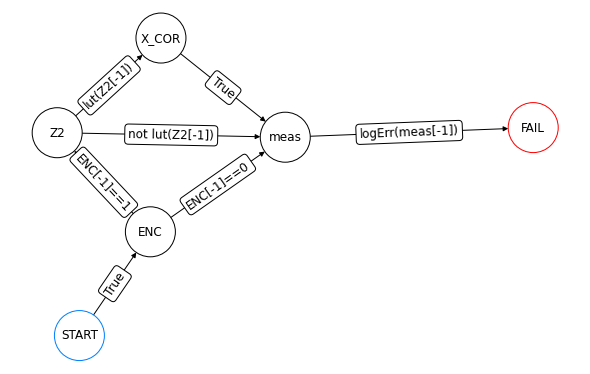

In [5]:
steane0.draw(figsize=(8,5))

In [6]:
err_model = qs.noise.E1
p_phys = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.5]
err_params = {'q': p_phys}

In [7]:
begin = time.time()
ss_sam = qs.SubsetSampler(protocol=steane0, simulator=qs.StabilizerSimulator,  p_max={'q': 0.1}, err_model=err_model, err_params=err_params, L=3)
ss_sam.run(1000)
end = time.time()
qsample_time = end-begin

p=('1.00e-01',):   0%|          | 0/1000 [00:00<?, ?it/s]

## STIM

In [8]:
ENC = """H 0 1 3\nDEPOLARIZE1({q}) 0 1 3\n
                    CNOT 0 4\nDEPOLARIZE2({q}) 0 4\n
                    CNOT 1 2\nDEPOLARIZE2({q}) 1 2\n
                    CNOT 3 5\nDEPOLARIZE2({q}) 3 5\n
                    CNOT 0 6\nDEPOLARIZE2({q}) 0 6\n
                    CNOT 3 4\nDEPOLARIZE2({q}) 3 4\n
                    CNOT 1 5\nDEPOLARIZE2({q}) 1 5\n
                    CNOT 0 2\nDEPOLARIZE2({q}) 0 2\n
                    CNOT 5 6\nDEPOLARIZE2({q}) 5 6\n
                    CNOT 4 7\nDEPOLARIZE2({q}) 4 7\n
                    CNOT 2 7\nDEPOLARIZE2({q}) 2 7\n
                    CNOT 5 7\nDEPOLARIZE2({q}) 5 7\n
                    M 7\nDETECTOR rec[-1]
                      """

sz_123 = """CNOT 0 8\nDEPOLARIZE2({q}) 0 8\n
            CNOT 1 8\nDEPOLARIZE2({q}) 1 8\n
            CNOT 3 8\nDEPOLARIZE2({q}) 3 8\n
            CNOT 6 8\nDEPOLARIZE2({q}) 6 8\n
                        M 8\nDETECTOR rec[-1]\n
                        TICK\n
                        """

x_cor = """X 6\nDEPOLARIZE1({q}) 6\n"""

meas7 = "\nTICK\nM 0 1 2 3 4 5 6\n"


KZ1 = """\nCNOT 3 9\nCNOT 4 9\nCNOT 5 9\nCNOT 6 9\nM 9\nDETECTOR rec[-1]\n"""
KZ2 = """\nCNOT 0 10\nCNOT 2 10\nCNOT 4 10\nCNOT 6 10\nM 10\nDETECTOR rec[-1]\n"""
KZ3 = """\nCNOT 1 11\nCNOT 2 11\nCNOT 5 11\nCNOT 6 11\nM 11\nDETECTOR rec[-1]\n"""


LOG_Z = """\nCNOT 0 12\nCNOT 1 12\nCNOT 2 12\nCNOT 3 12\nCNOT 4 12\nCNOT 5 12\nCNOT 6 12\nM 12\nDETECTOR rec[-1]"""

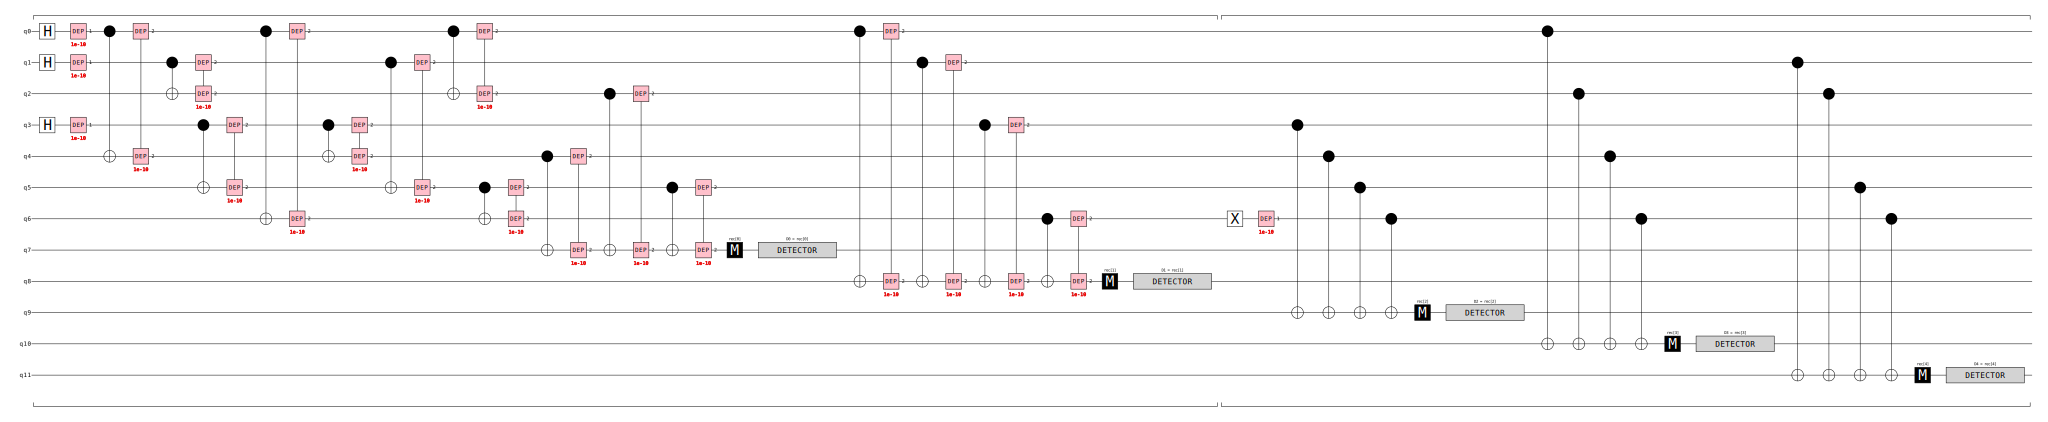

In [9]:
circuit = stim.Circuit((ENC+sz_123+x_cor+KZ1+KZ2+KZ3).format(q=1e-10))
circuit.diagram('timeline-svg')

In [10]:
meas = node(meas7+LOG_Z)
meas.outcomes = {0:"OK", 1:"FAIL"}

def x(n):
    return """\nX {}""".format(n)

kz1 = node(KZ1+KZ2+KZ3)
kz1.outcomes = {'000': meas, '001': node(x(1)).extend(meas), '010':node(x(0)).extend(meas), 
                '011': node(x(2)).extend(meas), '100': node(x(3)).extend(meas), 
                '101':node(x(5)).extend(meas), '110': node(x(4)).extend(meas), '111':node(x(6)).extend(meas)}

xkz1 = node(x_cor+KZ1+KZ2+KZ3)
xkz1.outcomes = kz1.outcomes

sz = node(sz_123)
sz.outcomes={0:kz1, 1:xkz1}

enc = node(ENC)
enc.outcomes = {0:kz1, 1:sz}

[1, 1, 0, 0, 0, 1]


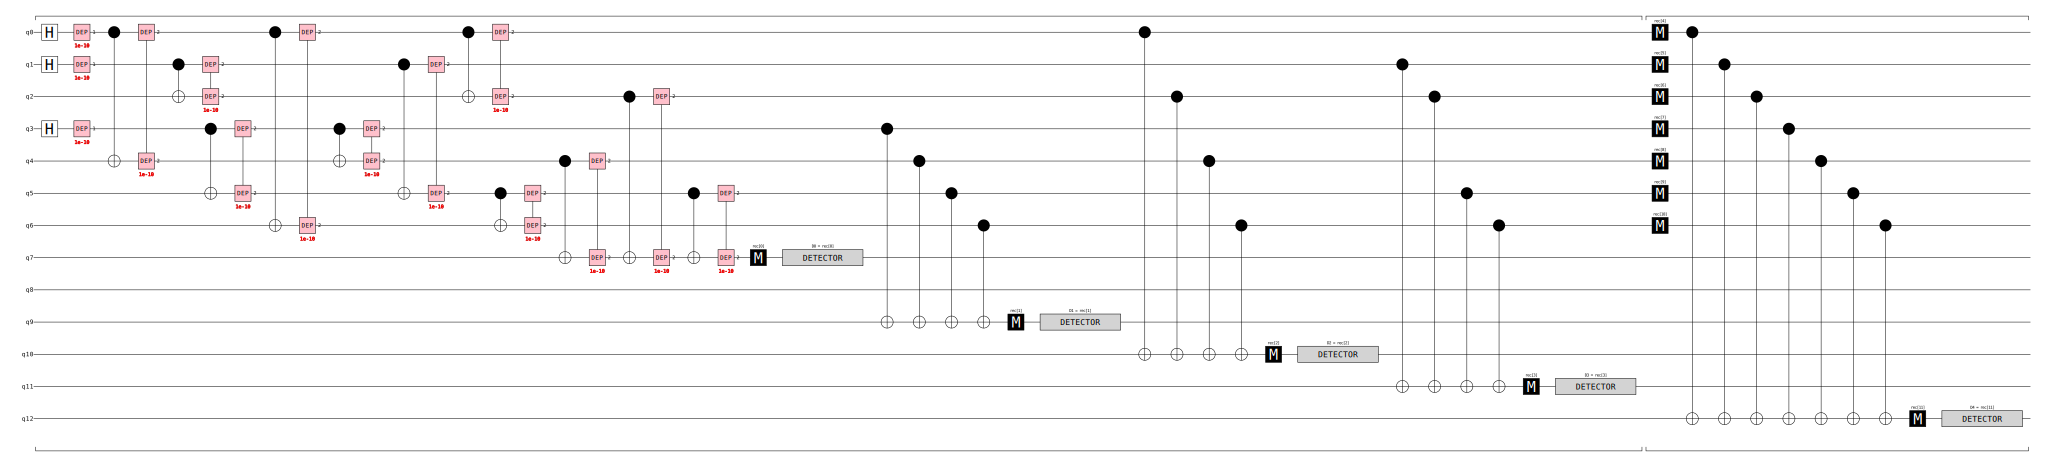

In [11]:
paths, circuits = enc.fail_paths()
print(paths[16])
circuit = stim.Circuit(circuits[0].format(q=1e-10))
circuit.diagram('timeline-svg')

# Comparison

In [12]:
def to_string(array):
    s = ''
    for i in array:
        s+=str(i)
    return s

In [13]:
def load_data(key):
    
    n_detectors = key['n_detectors']
    detector_outcomes = key['detector_outcomes']
    error_locations = key['error_locations']
    extracted = key['extracted']
    extracted_indices = key['extracted_indices']
    error_combinations = key['error_combinations']
    
    return n_detectors, detector_outcomes, error_locations, extracted, extracted_indices, error_combinations
    
def update_cache(cache_key, path, circuit):
    # creates new entry for cache dictionary
    
    # Simulate circuit with arbitrarily small error rate, just to extract the dem
    sample_circuit = stim.Circuit(circuit.format(q=1e-10))
    dem = sample_circuit.detector_error_model()
    error_rates, error_locations = dem2matrices(repr(dem),len(path))
    n_errors = len(error_rates)
    n_detectors = len(path)


    sampler = sample_circuit.compile_sampler()
    noiseless_outcome = sampler.sample(shots=1) # Use a noiseless (here actually with p_phys=1e-10) execution to find the actual detector flips we want
    detector_outcomes = np.copy(path)
    
    # Only for Steane
    detector_outcomes[:-1]-noiseless_outcome[0,:-8]
    detector_outcomes[-1]-=noiseless_outcome[0,-1]

    extracted, extracted_indices = separate_errors(error_locations, n_detectors)

    cache_values = dict({'circuit':circuit, 
                         'n_detectors': n_detectors, 
                         'detector_outcomes':detector_outcomes,
                         'error_locations':error_locations, 
                         'extracted':extracted, 
                         'extracted_indices':extracted_indices,
                        'error_combinations':[]})
    return cache_values

In [14]:
def sample_circuits(n_samples, paths, circuits):
    
    cache = dict() # dictionary that will store the data for each circuit sampled from the fail_paths

    for _ in range(n_samples):

        p = random.randint(0,len(paths)-1) # sample another circuit
        cache_key = to_string(paths[p]) # the circuit will be identified by its measurement sequence, 
                                        # not by its index in paths
            
        # if new circuit, create entry for cache dictionary 
        if cache_key not in cache:
            cache_values=update_cache(cache_key, paths[p], circuits[p])
            cache.update({cache_key: cache_values})
        
        # load data from entry in cache
        n_detectors, detector_outcomes, error_locations, extracted, extracted_indices, error_combinations = load_data(cache[cache_key])

        # finds a set of possible errors that result in desired error sequence
        error_set = sample_errors(n_detectors, detector_outcomes, error_locations, extracted, extracted_indices)# All generated error combinations

        # only include error set if it was successful
        if error_set is not None:
            error_combinations.append(error_set)
            
    return cache

In [15]:
def estimate_error_rate(node, n_samples):
    
    errors_p_phys = np.zeros(len(p_phys)) # array with the error rate for each p_phys
    paths, circuits = node.fail_paths()

    cache=sample_circuits(n_samples, paths, circuits)
        
    # Now apply the error combinations to the error rates we actually care about 
    
    for key in cache.keys():
        unique_error_combinations = np.unique(cache[key]['error_combinations'], axis=0) # Remove repeated combinations 
        
        # If there was at least one error combination generating the desired sequence
        if len(unique_error_combinations)>0: 
            
            for i in range(len(p_phys)):
                circuit = stim.Circuit(cache[key]['circuit'].format(q=p_phys[i]))
                dem = circuit.detector_error_model()
                error_rates, error_locations = dem2matrices(repr(dem),cache[key]['n_detectors'])
                
                # Calculate the total error rate of all generated combinations for given circuit
                errors_p_phys[i]+= np.sum(np.prod(error_rates*unique_error_combinations+
                                                  (1-error_rates)*(1-unique_error_combinations), axis=1))  

    return errors_p_phys

In [22]:
begin = time.time()

all_errors = estimate_error_rate(enc, 10000)

end = time.time()
stim_time = end-begin

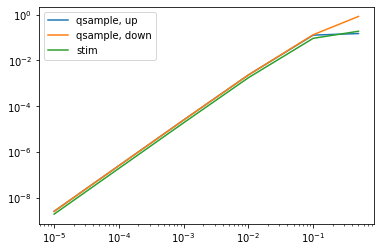

In [23]:
plt.plot(p_phys, ss_sam.stats()[0], label = 'qsample, up')
plt.plot(p_phys, ss_sam.stats()[2], label = 'qsample, down')
plt.plot(p_phys, all_errors, label = 'stim')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [24]:
print("QSample time: {:.3}s".format(qsample_time))
print("STIM time: {:.3}s".format(stim_time))
print(qsample_time/stim_time)

QSample time: 0.957s
STIM time: 0.784s
1.2219174847463052
